# Python網路爬蟲實戰研習馬拉松期末專題

## PTT 政黑板：
https://www.ptt.cc/bbs/HatePolitics/index.html


## 基本目標

1. 爬下文章，透過 jieba 將文章拆解
2. 簡單計算同樣文字出現的頻率或是透過 TF-IDF 的統計方式計算
3. 將經常出現的 stop words過濾掉之後進行排名
4. 將結果透過 wordcloud 文字雲的方式呈現

### 設定Headers和Cookies

In [1]:
import requests
from bs4 import BeautifulSoup as BS
import os 
import jieba
import jieba.analyse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import imageio
from lxml import etree 
import pandas as pd
from IPython.display import display

url = 'https://www.ptt.cc/bbs/HatePolitics/index.html'
myHeaders = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:71.0) Gecko/20100101 Firefox/71.0'}
myCookies = {'over18':'1'}

### 利用 jeiba分析字詞

* 設定dictionary為繁體中文
* 設定自定義的詞彙庫 (人名、專有名詞...等)
* 設定 stopwords 以過濾常用字詞但是無分析價值 

In [2]:
import os 
import jieba
import jieba.analyse
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict('userdict.txt')  #自定義詞彙  (自己建一個txt檔案把關鍵字打進去)
jieba.analyse.set_stop_words('stopwords.txt')

def wordAnalyse(dataList, keywordsNum):
    with open( 'stopwords.txt' ,'r', encoding = 'utf-8') as fh:
        stopWords = fh.readlines() #readlines回傳值本身就是個list
        fh.close()
    stopWords = [ w.strip() for w in stopWords ] # strip除去 '\n' '\t' ' '
    
    content = ''
    for d in dataList:
        content += d + ' '
    words = jieba.cut(content, cut_all = False) #預設為False
    filterWords_list = [ w for w in words if w not in stopWords]
    filterWords_str = ''.join(filterWords_list)  #list 轉 str
    
    tags = jieba.analyse.extract_tags(filterWords_str, keywordsNum)
    for t in tags:
        print(t , ':' , filterWords_list.count(t))
    return tags

Building prefix dict from C:\Users\User\Downloads\期末專題 2\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u48e3b28315ce8206b28a387649b231cd.cache
Loading model cost 0.967 seconds.
Prefix dict has been built successfully.


### 利用 wordcloud 產生文字雲 
* 設定遮罩圖片
* 設定文字格式

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import imageio
def makePlot(keywords_list):  #傳進來是list
    keywords = ' '.join(keywords_list)
    mask_pic = imageio.imread('subway.jpg')
    cloudPlot = WordCloud(background_color = 'white', font_path = 'kaiu.ttf', mask = mask_pic)
    cloudPlot.generate(keywords)
    plt.imshow(cloudPlot)
    plt.axis('off')
    plt.show()

### PTT網頁爬取
* 爬取每個文章的連結再做更深入的資料爬取

In [4]:
def PTTsearch(url , titleList, authorList, timeList, ipList, contentList):
    res = requests.get(url,headers = myHeaders,cookies= myCookies)
    soup = BS(res.text,'html5lib')
    titleAll = soup.find_all(class_='title')
    for t in titleAll:
        if('公告' not in t.text and '總統與立委選舉當選名單與心得' not in t.text and '對賭文開獎專區' not in t.text):
            try:
                link = t.find('a')['href']
                articleLink = 'https://www.ptt.cc'+ link             
                findInfo(articleLink, titleList, authorList, timeList, ipList, contentList)
            except:
                continue

#### PTT文章爬取
* 將爬取到的 標題、作者、時間、IP、內容 匯入各自的 List以做之後分析

In [5]:
from lxml import etree 

def findInfo(articleLink, titleList, authorList, timeList, ipList, contentList):
    resLink = requests.get(articleLink, headers = myHeaders, cookies= myCookies)
    soupArticle = BS(resLink.text,'html5lib')
    metaValue = soupArticle.find_all(class_= 'article-meta-value')
    author = metaValue[0].text
    for a in author:
        if(a =='('):
            author = author[:author.index(a)]
            break
    title = metaValue[2].text
    time = metaValue[3].text
    ip = IPsearch(soupArticle)
    titleList.append(title)
    authorList.append(author)
    timeList.append(time)
    ipList.append(ip)
    #找到內文的方式 
    selector = etree.HTML(resLink.text)
    results = selector.xpath('//*[@id="main-content"]/text()')
    content = ''
    for re in results:
        content += (re.replace('\n','').replace(' ',''))
    contentList.append(content)

* IP爬取的部分獨立寫個Function做更詳細的資訊切割 

In [6]:
def IPsearch(soup):
    findF2 = soup.find_all('span', class_='f2')
    for f in findF2:
        if( f.string is None):
            continue
        elif ( 'ptt.cc' in f.string):
            ipColumn = f.string
            break
    start = 0
    end = 0
    for i in range(len(ipColumn)-1 , 0 , -1):
        if(ipColumn[i] == '('):
            end = i-2
        if(ipColumn[i] == ':'):
            start = i+2
            break
    ipNum = ipColumn[start:end]
    return ipNum

## 所有的功能彙整在此
* 設定頁數 (輸入-1則會 Loop 到 PTT網頁的最後一頁)
* 設定 keywords 數量 
* 設定儲存資料的各個 List

In [7]:
def loopSearch( url, pagesAmount, keywordsNum , titleList, authorList, timeList, ipList,contentList):
    count = 0
    if(pagesAmount == -1):
        print('Infinite Search')
        while(1):
            titleList = PTTsearch(url, titleList, authorList, timeList, ipList, contentList)
            res = requests.get( url, headers = myHeaders, cookies= myCookies)
            soup = BS(res.text,'html5lib')
            btnsBox = soup.find(class_='btn-group btn-group-paging')
            btns = btnsBox.find_all('a')
            btnEnd = btnsBox.find(class_='btn wide disabled')
            count +=1
            #print('end of page ', count)
            
            if(btnEnd is not None and btnEnd.text =='‹ 上頁'):
                break
            else:
                nextLink = btns[1]['href']
                url = 'https://www.ptt.cc'+ nextLink
                
    elif(pagesAmount > 0 ):
        print('Search Pages:', pagesAmount)
        for i in range(pagesAmount):
            PTTsearch(url, titleList, authorList, timeList, ipList, contentList)
            res = requests.get( url, headers = myHeaders, cookies= myCookies)
            soup = BS(res.text,'html5lib')
            btnsBox = soup.find(class_='btn-group btn-group-paging')
            btns = btnsBox.find_all('a')
            btnEnd = btnsBox.find(class_='btn wide disabled')
            #print('end of page ', i+1)
            
            if(btnEnd is not None and btnEnd.text == '‹ 上頁'):
                break
            else:
                nextLink = btns[1]['href']
                url = 'https://www.ptt.cc'+ nextLink
    else:
        print('Unable to search')
        return
        
        
    print('Title keywords:')
    keywords_T = wordAnalyse( allTitleList, keywordsNum)
    #print(keywords_T)
    makePlot(keywords_T)
    print('-'*50)
    print('Content keywords:')
    keywords_C = wordAnalyse( contentList, keywordsNum)
    #print(keywords_C)
    makePlot(keywords_C)

    

start
Search Pages: 100
Title keywords:
柯文哲 : 181
中國 : 110
民進黨 : 96
武漢 : 90
防疫 : 102
公開 : 66
肺炎 : 83
確診 : 48
口罩 : 64
出國 : 47
24 : 48
血友病 : 48
柯粉 : 45
黃珊珊 : 40
國民黨 : 39
韓國瑜 : 36
社區 : 35
疫情 : 48
桑德斯 : 29
美國 : 31
指揮中心 : 29
公布 : 66
侯友宜 : 26
蔡英文 : 24
人員 : 23
地點 : 23
總統 : 22
感染 : 37
市長 : 21
江啟 : 23


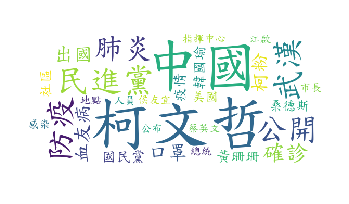

--------------------------------------------------
Content keywords:
中國 : 1164
防疫 : 1098
武漢 : 850
柯文哲 : 734
疫情 : 1005
民進黨 : 630
肺炎 : 744
國民黨 : 539
美國 : 516
確診 : 490
口罩 : 638
公開 : 459
市長 : 434
國家 : 416
社區 : 409
大陸 : 401
政府 : 1011
感染 : 610
認為 : 328
隔離 : 316
總統 : 307
人員 : 297
韓國瑜 : 291
檢疫 : 288
立委 : 239
24 : 282
時間 : 273
記者 : 266
相關 : 251
報導 : 248


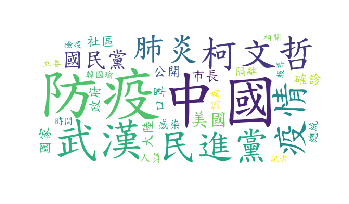

end


In [8]:
allTitleList = list()
allAuthorList = list()
allTimeList = list()
allIpList = list()
allContentList = list()

print('start')
pagesAmount = 100
keywordsNum = 30
loopSearch( url, pagesAmount, keywordsNum, allTitleList, 
           allAuthorList, allTimeList, allIpList, allContentList)
print('end')

### 利用pandas製作圖表

In [15]:
import pandas as pd
from IPython.display import display
def makeFrame( titleList, authorList, timeList, ipList ):
    frame = pd.DataFrame({'標題': titleList,
                         '發文者': authorList,
                          'IP': ipList,
                         '時間': timeList})
    frame.set_index('發文者')    
    display(frame)


In [16]:
makeFrame( allTitleList, allAuthorList, allTimeList, allIpList)

,標題,發文者,IP,時間
0,[討論] 拿賴香伶比黃國昌，是不是過譽,joy830,180.217.139.3,Mon Feb 24 18:24:25 2020
1,Re: [討論] 誰存款300萬，敢負債5600萬,ihaveseven,1.200.201.8,Mon Feb 24 18:25:41 2020
2,[黑特] 為什麼柯文哲順時中綠粉也不高興？,ray90910,61.60.221.12,Mon Feb 24 18:25:49 2020
3,[討論] 防疫目前看來問題越來越大,cplusplus426,101.8.225.21,Mon Feb 24 18:30:03 2020
4,[討論] 2020總統選舉各立委選區得票,Neptunium,114.44.6.2,Mon Jan 20 23:09:27 2020
...,...,...,...,...
1928,Re: [新聞] 吳斯懷首次質詢內容曝光 批蔡總統挑釁,abduraff,150.116.31.5,Wed Feb 19 23:22:17 2020
1929,[討論] 是不是可以考慮罷免蔡英文了?,LoveWin7,123.193.71.15,Wed Feb 19 23:24:10 2020
1930,Re: [黑特] 馬鷹狗是還有要選里長還是什麼小的嗎？,yun0615ch,27.52.62.24,Wed Feb 19 23:25:10 2020
1931,[討論] 勤洗手有效用嗎,surimodo,42.72.232.25,Wed Feb 19 23:28:00 2020


## 進階目標

1. 透過不同帳號，但是IP相同且政治用語的詞頻分布類似的定位成網軍
2. 進⼀一步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性
3. 如果不同帳號但是政治用語的詞頻分佈類似，進⼀步判斷這些高頻率的單字是
   positive / negative 來歸納兩個帳號之間是否具有相同政治立場


In [39]:
keyIp = list()
keyAuthor = list()
def IpAnalyse(ipNum):
    topIp = wordAnalyse( allIpList, ipNum)
    
    tempAuthor=' '
    for t in topIp:
        for i in range(len(allIpList)):
            if( t in allIpList[i].strip()):
                keyIp.append(allIpList[i])
                keyAuthor.append(allAuthorList[i])

ipNum = 10
IpAnalyse(ipNum)
print('-'*50)
record=list()
for i in range(len(keyIp)):
    if keyIp[i] not in record:
        record.append(keyIp[i])
        for j in range(i+1, len(keyIp)):
            if(keyIp[i] == keyIp[j] and keyAuthor[i] != keyAuthor[j]):
                print(  keyIp[i], ':' ,keyAuthor[i])
                print( '相同IP的帳號: ',keyAuthor[j])
    else:
        pass
    
ipFrame = pd.DataFrame({'IP':keyIp,
                        'Author': keyAuthor})
display(ipFrame)


111.71 : 54
223.137 : 51
180.217 : 46
49.216 : 41
223.141 : 36
123.194 : 35
223.140 : 35
223.136 : 34
36.230 : 33
27.247 : 30
--------------------------------------------------
223.137.4.18 : liu270990 
相同IP的帳號:  cycling 
223.141.168.8 : Acalanatha 
相同IP的帳號:  rodneytw 
223.141.168.8 : Acalanatha 
相同IP的帳號:  rodneytw 
223.136.116.1 : michaeljim90 
相同IP的帳號:  Mark0529 


,IP,Author
0,111.71.215.12,clark0816
1,111.71.215.12,clark0816
2,111.71.44.22,trustinme
3,111.71.59.4,coober
4,111.71.44.22,trustinme
...,...,...
391,27.247.105.4,nicholas0406
392,27.247.105.4,nicholas0406
393,27.247.32.23,wwHui
394,27.247.73.25,zangetsu9006


start
jordanlove : 24
coober : 24
kiki2125 : 21
tontontonni : 19
OusakaMegumu : 19
Zcould : 19
jerry78424 : 17
yuxds : 17
songgood : 17
nicholas0406 : 16
Searching Target: jordanlove
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Ajordanlove
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


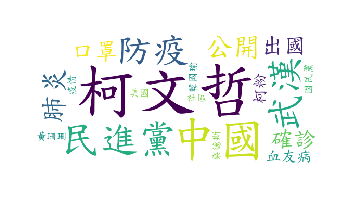

--------------------------------------------------
Content keywords:
中國 : 17
其實 : 15
比較 : 14
總統 : 14
感覺 : 14
立委 : 12
政黨 : 13
香港 : 23
覺青 : 11
美國 : 11
民進黨 : 11
國民黨 : 11
很多 : 25
國家 : 10
問題 : 10
英粉 : 9
韓國瑜 : 9
喜歡 : 9
連任 : 9
市長 : 8


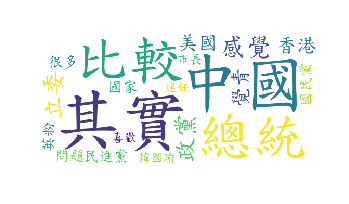

,標題,發文者,IP,時間
0,[討論] 親中的是不是選錯了,jordanlove,27.52.201.15,Mon Feb 24 14:39:00 2020
1,[討論] 大家最不滿意蔡政府哪個地方,jordanlove,27.52.201.15,Mon Feb 24 12:50:12 2020
2,[討論] 越來越覺得執政黨跟共產黨好像？,jordanlove,27.52.201.15,Mon Feb 24 08:33:33 2020
3,[討論] 香港人知不知道自己被食人血饅頭了,jordanlove,39.10.192.4,Sun Feb 23 19:55:23 2020
4,[討論] 英粉覺青為什麼可以那麼沒下限,jordanlove,39.10.192.4,Sun Feb 23 18:50:35 2020
...,...,...,...,...
95,[討論] 如果韓國瑜當上國家元首？,jordanlove,110.26.30.8,Mon Dec 30 15:56:53 2019
96,[討論] 明天的反滲透法,jordanlove,110.26.30.8,Mon Dec 30 12:44:06 2019
97,[討論] 網美網紅是不是都英粉,jordanlove,27.246.94.7,Mon Dec 30 10:31:36 2019
98,[討論] 倚老賣老的韓粉,jordanlove,27.246.94.7,Mon Dec 30 09:25:37 2019


Searching Target: coober
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Acoober
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


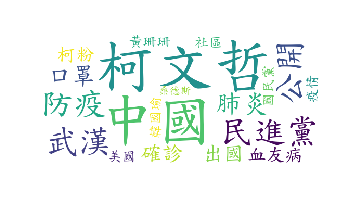

--------------------------------------------------
Content keywords:
中國 : 82
美國 : 50
國家 : 24
之後 : 22
武漢 : 19
柯糞 : 20
媒體 : 18
資源 : 16
認為 : 17
kmt : 15
東西 : 15
可能 : 46
這是 : 14
一定 : 37
dpp : 13
接下來 : 13
市長 : 13
員額 : 13
10 : 12
出現 : 12


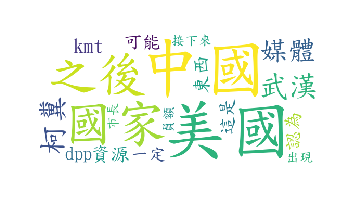

,標題,發文者,IP,時間
0,Re: [新聞] 民進黨支持度飆到41.1 游盈隆:1大3小確立,coober,111.71.59.4,Mon Feb 24 12:09:13 2020
1,Re: [討論] 如果桑德斯對上川普,coober,223.137.231.20,Mon Feb 24 08:54:22 2020
2,[討論] 不能否認一點 就是柯很急~,coober,111.71.73.1,Mon Feb 24 05:59:07 2020
3,Re: [黑特] 政府自己風向都搞不定笑死人,coober,111.71.73.1,Mon Feb 24 04:34:04 2020
4,Re: [討論] 柯文哲的公開透明要公開到什麼程度？,coober,111.71.73.1,Sun Feb 23 03:39:08 2020
...,...,...,...,...
95,Re: [討論] 反滲透法對民進黨、蔡英文會扣分嗎？,coober,114.136.8.19,Fri Dec 27 10:42:33 2019
96,Re: [討論] 反對反滲透法是不是在幫民進黨催票？,coober,114.136.8.19,Fri Dec 27 02:55:58 2019
97,[討論] 泛藍兄弟大團結的戲碼,coober,114.136.8.19,Thu Dec 26 12:43:35 2019
98,Re: [討論] 震撼！柯陣營正式表態投韓國瑜！,coober,114.136.8.19,Thu Dec 26 11:48:23 2019


Searching Target: kiki2125
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Akiki2125
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


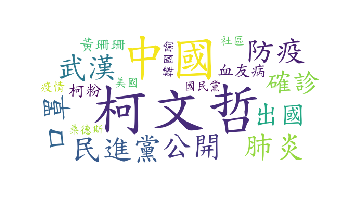

--------------------------------------------------
Content keywords:
中國 : 110
武漢 : 49
國民黨 : 37
柯文哲 : 36
柯糞 : 34
共產黨 : 30
CF : 26
請問 : 23
阿北 : 26
台商 : 25
口罩 : 26
斷航 : 19
美國 : 19
肺炎 : 20
不要 : 37
回來 : 14
疫情 : 20
防疫 : 16
開工 : 11
國家 : 13


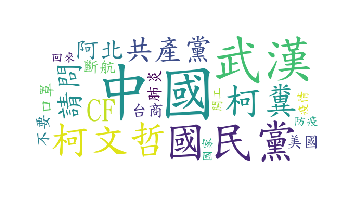

,標題,發文者,IP,時間
0,[討論] 柯文哲就是小丑不要理會,kiki2125,123.194.172.1,Sun Feb 23 03:15:58 2020
1,[討論] 柯文哲為什麼要幫中國洗地,kiki2125,223.140.98.20,Sat Feb 22 19:46:32 2020
2,[討論] 柯文哲很像武漢肺炎病毒,kiki2125,123.194.172.1,Sat Feb 22 14:07:05 2020
3,Re: [討論] 中國目前復工情況？,kiki2125,123.194.172.1,Sat Feb 22 10:31:55 2020
4,[討論] 請立即斷航中國所有航線,kiki2125,123.194.172.1,Sat Feb 22 05:31:03 2020
...,...,...,...,...
95,[轉錄] 只是堵藍FB-陳秋實武統台灣影片,kiki2125,123.194.172.1,Wed Jan 29 16:35:40 2020
96,[討論] 台灣官員素質很優吧,kiki2125,123.194.172.1,Wed Jan 29 13:37:01 2020
97,Re: [討論] 如何評價馬英九這波操作？,kiki2125,123.194.172.1,Wed Jan 29 12:57:14 2020
98,[討論] 台商若回中國 困住別再喊救命,kiki2125,123.194.172.1,Wed Jan 29 11:09:29 2020


Searching Target: tontontonni
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Atontontonni
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


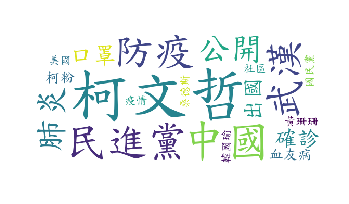

--------------------------------------------------
Content keywords:
說謊 : 106
博士論文 : 55
LSE : 48
論文 : 45
博士 : 58
總統 : 33
蔡英文 : 31
口試 : 25
1.5 : 23
諾貝爾文學獎 : 21
索忍尼辛 : 21
得主 : 21
英國 : 15
報告 : 11
學位 : 10
依然 : 21
817 : 9
發展 : 9
通知書 : 9
演講 : 9


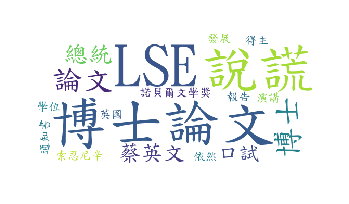

,標題,發文者,IP,時間
0,[黑特] 跟我一起唱～～～,tontontonni,39.12.0.16,Mon Feb 24 18:38:28 2020
1,[黑特] 台灣現在是英曹地府？,tontontonni,39.12.0.16,Mon Feb 24 18:19:51 2020
2,[黑特] 現在只有民進黨和蟑螂可以用健保？,tontontonni,39.12.0.16,Mon Feb 24 17:49:49 2020
3,Re: [新聞] 韓國人「想和台灣換總統」 陳嘉行得意虧,tontontonni,39.12.64.4,Sun Feb 23 18:38:04 2020
4,[討論] 相信蔡英文是真1.5個博士請+1,tontontonni,27.242.40.25,Sun Feb 23 14:14:34 2020
5,Re: [討論] 政經幹麼一直拿 格達費之子的論文,tontontonni,27.242.40.25,Sun Feb 23 11:19:46 2020
6,"[轉錄] 蔡英文的指導學生""整本抄""(檢察署)",tontontonni,1.162.160.2,Sun Feb 23 10:40:08 2020
7,Re: [討論] wecare?,tontontonni,27.52.40.18,Sun Feb 23 02:00:58 2020
8,[討論] 家長要如何跟小孩說蔡總統讀博士的故事,tontontonni,39.12.42.24,Sat Feb 22 17:14:19 2020
9,[討論] 原來蔡英文才是時空旅人???,tontontonni,39.9.108.8,Sat Feb 22 10:40:51 2020


Searching Target: OusakaMegumu
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3AOusakaMegumu
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


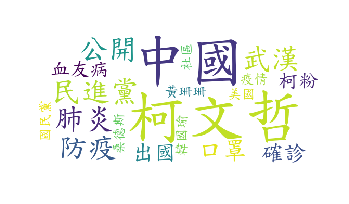

--------------------------------------------------
Content keywords:
選舉 : 183
國民黨 : 123
民主黨 : 112
選區 : 106
總統 : 104
大選 : 102
.-- : 101
onevoteisamostdifficultformofgovernment : 100
Fromtimetotime : 100
theresultscanbeerratic : 100
Peoplearesometimesfickle : 100
Theygetboredwithstable : 100
steadyimprovementsinlife : 100
andinarecklessmoment : 100
theyvoteforachangeforchange : 100
ssake : 100
Oneperson : 100
政黨 : 94
選民 : 94
初選 : 92


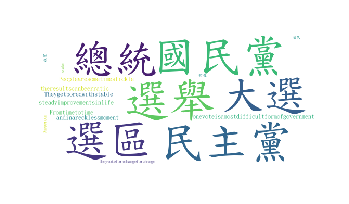

,標題,發文者,IP,時間
0,[新聞]希盟瓦解? 閃電大選? ·大事即將發生,OusakaMegumu,128.199.72.20,Sun Feb 23 19:44:33 2020
1,[新聞]伊朗大選 反美情緒助強硬派領先,OusakaMegumu,128.199.72.20,Sun Feb 23 19:18:55 2020
2,Fw: [新聞]美民主黨初選問題多 愛阿華之亂內華達再現,OusakaMegumu,128.199.72.20,Sun Feb 23 19:05:57 2020
3,[新聞]違參選規定 莫拉萊斯被褫奪參院選舉資格,OusakaMegumu,128.199.65.21,Sat Feb 22 21:35:21 2020
4,[新聞]第3場初選內州戰場 白登非裔支持率急降 看,OusakaMegumu,128.199.65.21,Sat Feb 22 21:16:46 2020
...,...,...,...,...
95,[新聞]本土藍青年聯盟發聲 籲跨派系支持韓國瑜,OusakaMegumu,128.199.73.13,Tue Dec 24 19:24:04 2019
96,Re: [新聞]20位基督徒政治庶民參選立委 合一行動聯盟,OusakaMegumu,128.199.74.1,Mon Dec 23 20:28:05 2019
97,Re: [新聞]喜樂島聯盟提名 台東市代巫化．巴阿立佑司,OusakaMegumu,128.199.74.1,Mon Dec 23 20:18:09 2019
98,[新聞]各州初選將登場 民主黨選將把握機會跑基層,OusakaMegumu,128.199.74.1,Mon Dec 23 10:35:08 2019


Searching Target: Zcould
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3AZcould
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


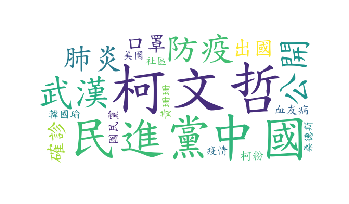

--------------------------------------------------
Content keywords:
中國 : 27
武漢 : 22
病毒 : 28
爆發 : 17
習近平 : 14
恐慌 : 22
之後 : 14
疫情 : 19
有人 : 31
地點 : 12
口罩 : 16
肺炎 : 16
立委 : 9
防疫 : 12
選舉 : 10
傳染 : 10
隔離 : 10
美國 : 10
聽說 : 9
過去 : 9


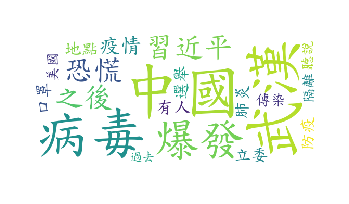

,標題,發文者,IP,時間
0,[討論] 我賭那個人他今年不會因血友病而死,Zcould,36.230.81.23,Mon Feb 24 00:14:57 2020
1,[討論] 為何台灣人過去所有恐慌之後都沒怎樣？,Zcould,36.230.81.23,Sun Feb 23 22:46:47 2020
2,[討論] 染上武漢肺炎跟沒錢哪個慘？,Zcould,223.137.240.,Sun Feb 23 12:49:15 2020
3,[討論] 何時有政府承認沒辦法要人民自求多福？,Zcould,36.230.81.23,Sun Feb 23 09:52:34 2020
4,[討論] 柯文哲不怕被罷免嗎？,Zcould,36.230.81.23,Sun Feb 23 00:46:27 2020
...,...,...,...,...
95,[討論] 為何因政治而決裂的家人都過得不錯？,Zcould,36.229.162.7,Tue Jan 14 09:44:12 2020
96,[討論] 我支持兩岸統一，一國一制，你呢？,Zcould,36.229.162.7,Tue Jan 14 09:17:02 2020
97,[討論] 為何立法院長蘇嘉全毫無存在感？,Zcould,36.229.162.7,Mon Jan 13 23:59:36 2020
98,[討論] 國民黨不改親中路線才才是台灣之福,Zcould,36.229.162.7,Mon Jan 13 22:27:54 2020


Searching Target: jerry78424
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Ajerry78424
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


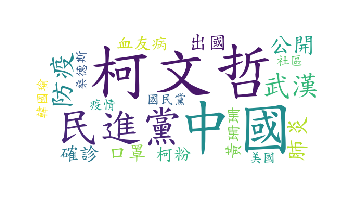

--------------------------------------------------
Content keywords:
中國 : 180
英國 : 85
美國 : 87
華為 : 72
國家 : 60
5G : 55
武漢 : 51
口罩 : 61
蔡英文 : 43
決定 : 35
網絡 : 34
歐盟 : 31
防疫 : 32
建設 : 25
丹尼爾 : 25
隔離 : 24
選舉 : 24
香港 : 48
醫院 : 22
之後 : 22


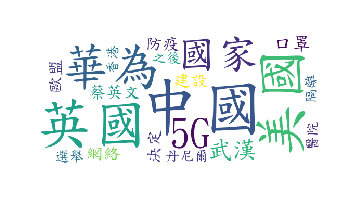

,標題,發文者,IP,時間
0,[討論] 原來陳建仁有這種黑歷史....,jerry78424,36.230.229.20,Mon Feb 24 16:17:00 2020
1,[討論] 哪些電視台有和諧用詞？,jerry78424,223.137.147.20,Mon Feb 24 14:18:46 2020
2,[討論] 把鬥爭的精力用在防疫不是更好嗎？,jerry78424,223.137.147.20,Sun Feb 23 20:55:12 2020
3,[討論] 台灣超日趕韓指日可待？,jerry78424,223.137.147.20,Sat Feb 22 16:38:30 2020
4,Re: [轉錄] 中研院研究員吳介民：臺灣人別想輕鬆過日,jerry78424,223.137.147.20,Sat Feb 22 15:15:06 2020
...,...,...,...,...
95,[黑特] 柯文哲再不轉彎就連白海豚都不如,jerry78424,223.137.127.24,Sat Jan 18 14:51:51 2020
96,[討論] 國民黨人很忌諱1945-1949這四年？,jerry78424,36.226.57.2,Sat Jan 18 12:04:20 2020
97,Re: [新聞] 大選完美豬核食會進來嗎？ 黃暐瀚：會，,jerry78424,223.136.161.11,Fri Jan 17 23:55:30 2020
98,[新聞],jerry78424,36.226.57.2,Fri Jan 17 21:06:49 2020


Searching Target: yuxds
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Ayuxds
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


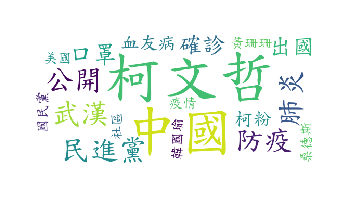

--------------------------------------------------
Content keywords:
時代 : 74
DPP : 75
立委 : 49
民進黨 : 44
國土 : 37
黃國 : 34
中國 : 30
總統 : 28
英粉 : 28
市長 : 26
選舉 : 25
未來 : 21
口罩 : 28
蔡英文 : 20
賴品 : 22
韓國瑜 : 20
國家 : 19
計畫 : 17
最後 : 17
社區 : 17


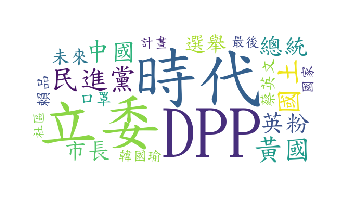

,標題,發文者,IP,時間
0,[討論] DPP政治考量>>>台灣人民健康,yuxds,111.241.74.10,Sun Feb 23 20:12:42 2020
1,[轉錄] 邱顯智-破壞環境正義的國土計畫法修正草,yuxds,111.241.74.10,Sun Feb 23 17:00:06 2020
2,[轉錄] 陳椒華-#現階段國土計畫已經放寬限制了,yuxds,111.241.74.10,Sun Feb 23 09:42:14 2020
3,Re: [討論] 柯文哲令人失望,yuxds,111.241.74.10,Sun Feb 23 09:28:23 2020
4,Re: [討論] 所以現在柯糞給防疫工作幾分？,yuxds,111.241.74.10,Sun Feb 23 02:36:10 2020
...,...,...,...,...
95,[轉錄] 鄭宏輝-小英總統蔡英文 團結大新竹,yuxds,36.228.203.14,Wed Jan 8 01:06:33 2020
96,[討論] 為什麼時代不直接要求亞泥收攤比較快?,yuxds,36.228.203.14,Wed Jan 8 00:50:21 2020
97,[轉錄] 邱毅-一齣自編自導的「假共諜案」上演了,yuxds,36.228.203.14,Tue Jan 7 06:25:23 2020
98,[轉錄] 人渣-不要醬子ㄇ，給人家一點活路ㄅ\,yuxds,36.228.203.14,Tue Jan 7 05:54:56 2020


Searching Target: songgood
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Asonggood
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


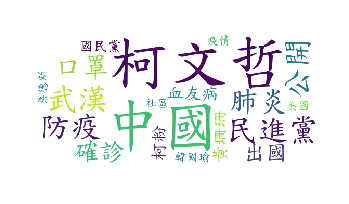

--------------------------------------------------
Content keywords:
昏倒 : 33
口罩 : 35
野豬 : 25
騎士 : 25
丁字褲 : 25
市長 : 25
這張 : 25
合照 : 25
防疫 : 28
kmt : 23
花音 : 17
遇到 : 35
肺炎 : 24
路上 : 33
dpp : 18
介紹 : 17
親送 : 17
泡溫泉 : 17
金臂 : 17
詩穗 : 17


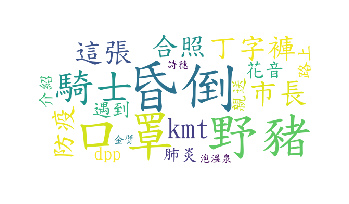

,標題,發文者,IP,時間
0,[討論] 黑幫會配合防疫檢查嗎,songgood,59.115.237.19,Sun Feb 23 11:20:43 2020
1,[討論] 台灣中國鄉民根本一個樣果然同醬缸出來的,songgood,59.115.237.19,Sun Feb 23 11:08:21 2020
2,Re: [討論]其實還好爆發在中國吧,songgood,36.229.214.6,Sun Feb 23 08:53:04 2020
3,[討論] 政經幹麼一直拿 格達費之子的論文,songgood,36.229.214.6,Sun Feb 23 08:43:12 2020
4,[討論] 博士論文在星期天口試很不正常嗎,songgood,36.229.214.6,Sun Feb 23 07:55:07 2020
...,...,...,...,...
95,[討論] 政經怎麼這幾天是在總編集嗎,songgood,59.115.235.9,Sat Feb 1 08:03:02 2020
96,Re: [討論] 尚毅夫是比較偏藍還是綠?,songgood,59.115.235.9,Sat Feb 1 07:28:53 2020
97,[討論] 武漢肺炎當初不隱滿 給各國研究是不是就,songgood,59.115.235.9,Sat Feb 1 07:08:44 2020
98,[討論] 現在人都會謝謝狗官吧,songgood,59.115.235.21,Fri Jan 31 11:59:50 2020


Searching Target: nicholas0406
https://www.ptt.cc/bbs/HatePolitics/search?q=author%3Anicholas0406
Search Pages: 5
Title keywords:
柯文哲 : 175
中國 : 113
民進黨 : 94
武漢 : 91
防疫 : 101
公開 : 66
肺炎 : 88
口罩 : 65
確診 : 47
24 : 48
出國 : 45
血友病 : 48
柯粉 : 46
黃珊珊 : 39
國民黨 : 36
韓國瑜 : 36
社區 : 35
疫情 : 50
美國 : 32
桑德斯 : 29


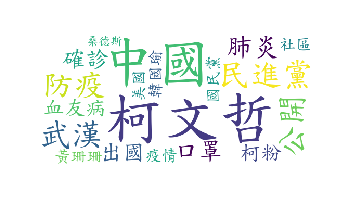

--------------------------------------------------
Content keywords:
柯文哲 : 147
柯粉 : 84
防疫 : 60
韓國瑜 : 47
武漢 : 45
國民黨 : 45
隔離 : 36
中國 : 36
口罩 : 42
韓粉 : 34
公開 : 29
罷免 : 29
台商 : 35
市長 : 26
民進黨 : 23
社會 : 24
返台 : 23
肺炎 : 30
暴雷 : 19
整個 : 16


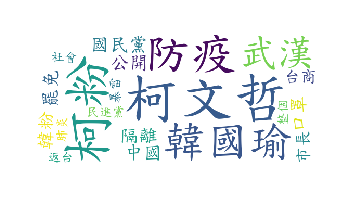

,標題,發文者,IP,時間
0,[討論] 柯文哲搞不清楚狀況 還跟陳時中嗆聲 真狂,nicholas0406,1.163.0.23,Sun Feb 23 12:37:17 2020
1,[討論] 馬B 柯文哲根本就狀況外 黃珊珊出來打臉,nicholas0406,1.163.0.23,Sun Feb 23 12:14:19 2020
2,[討論] 是不是全台灣最極端偏激的6%都在政黑阿 ?,nicholas0406,118.168.124.16,Sun Feb 23 02:51:16 2020
3,[討論] 柯文哲會不會是選擇性失憶或道聽塗說 ?,nicholas0406,118.168.124.16,Sat Feb 22 23:20:02 2020
4,[討論] 為什麼候友宜不公開透明 ? 公開24例,nicholas0406,27.247.105.4,Sat Feb 22 22:55:58 2020
...,...,...,...,...
95,[討論] 柯文哲這波暴雷，施政滿意度應該會上升吧,nicholas0406,39.9.164.10,Sun Feb 2 21:03:43 2020
96,[討論] 如果這波是桃園鄭文燦爆雷 柯粉會怎樣 ?,nicholas0406,39.9.164.10,Sun Feb 2 20:08:33 2020
97,[討論] 防疫視同作戰 柯文哲暴雷是什麼居心 ?,nicholas0406,39.9.164.10,Sun Feb 2 19:57:22 2020
98,[討論] 如果柯文哲真的被行政處分算是政治迫害嗎,nicholas0406,39.9.164.10,Sun Feb 2 19:26:48 2020


end


In [21]:
tempTitleList = list()
tempAuthorList = list()
tempTimeList = list()
tempIpList = list()
tempContentList = list()

def authorAnalyse(pagesAmount, keywordsNum, authorsNum):
    keyAuthor = wordAnalyse( allAuthorList, authorsNum)
    for author in keyAuthor:
        print('Searching Target:' , author)
        tempTitleList.clear()
        tempAuthorList.clear()
        tempTimeList.clear()
        tempIpList.clear()
        tempContentList.clear()
        
        authorLink = 'https://www.ptt.cc/bbs/HatePolitics/search?q=author%3A'+ author
        print(authorLink)
        loopSearch( authorLink, pagesAmount, keywordsNum, tempTitleList, tempAuthorList, tempTimeList, tempIpList, tempContentList)
        makeFrame( tempTitleList, tempAuthorList, tempTimeList, tempIpList )

pagesAmount = 5
keywordsNum = 20
authorsNum = 10
print('start')
authorAnalyse(pagesAmount, keywordsNum, authorsNum)
print('end')
